In [1]:
#### rewriting scripts to calculate neuronal activity at start of interaction
#### need to divide neurons into relevant categories (unimodal and multimodal)
### add option to run specific neurons (i.e. LA, BLA or BMA)

import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.gridspec as gridspec
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats

import import_ipynb
import func_format
import func_analysis

importing Jupyter notebook from func_format.ipynb
importing Jupyter notebook from func_analysis.ipynb


In [2]:
def extractusableint(modality, intcat, foldername, presentationnumber):
    if modality == 'female':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Female']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Female']
    elif modality == 'male':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
    elif modality == 'object':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
    elif modality == 'food':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Food']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Food']
    elif modality == 'social':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Female'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Female'])
    elif modality == 'nonsocial':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Food'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Food'])
    elif modality == 'panresponsive':
        usableint = foldername
        usablepresentationnumber = presentationnumber
    else:
        usableint = foldername
        usablepresentationnumber = presentationnumber
    
    return(usableint, usablepresentationnumber)

def order_pad_mask(spiketrain):

    lengths = []
    for i, fr in enumerate(spiketrain):
        fr = np.ravel(np.array(fr, np.float32))
        lengths = np.append(lengths, len(fr))

    maxlength = np.int(np.max(lengths))
    heatmaparray = np.zeros((len(spiketrain), maxlength))
    sortorder = np.argsort(lengths)
    
    for i, row in enumerate(np.argsort(lengths)):
        fr = np.ravel(np.array(spiketrain[row], np.float32))
        if len(fr) == np.int(np.max(lengths)):
            heatmaparray[i] = fr
        else:
            halfsizedifference = np.int(np.ceil((maxlength - lengths[row])/2))
            fr_padded = np.hstack((np.zeros(halfsizedifference+1), fr[1:-1], np.zeros(halfsizedifference+1)))
            if len(heatmaparray[i]) != len(fr_padded):
                fr_padded = fr_padded[:len(heatmaparray[i])]
            heatmaparray[i] = fr_padded
        
    heatmap_masked = np.ma.masked_where(heatmaparray == 0, heatmaparray)
    
    return(heatmap_masked, sortorder)

def plot_heatmap_rawvalues(heatmap_masked, color, vmin, vmax):
    
    fig, ax = plt.subplots(1, figsize = (10, 8))

    a = ax.imshow(heatmap_masked, aspect = 'auto', vmin = vmin, vmax = vmax, cmap = color, interpolation = None)
    #plt.ylim(600, 800)
    ax.grid(False)
    #ax.set_xlim(1200, 2200)
    #ax.set_xticks(np.arange(200, 1501, 100))
    #ax.set_xticklabels((np.linspace(0, 10*13, 14)))
    ax.set_xlabel('Time (s)')
    ax.set_yticks([])
    ax.set_facecolor('white')
    #plt.colorbar(a)
    
    return(fig)

def plot_sorted_timewarp(timewarp, vmin, vmax, color):
    sortorder = np.reshape(np.argsort(np.mean(timewarp[:,250:], axis = 1)), (len(timewarp), 1))

    timewarp_sorted = np.take_along_axis(timewarp, sortorder, axis = 0)
    
    plt.close()
    
    fig, ax = plt.subplots(1, figsize = (4, 4))
    a = ax.imshow(timewarp_sorted, vmin = vmin, vmax = vmax, cmap = color, aspect = 'auto')
    ax.set_ylim(0, len(timewarp_sorted))
    ax.vlines(99, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)
    ax.vlines(149, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)
    ax.vlines(349, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'k', alpha = 0.75, lw = 1)
    
    ax.set_xticks((0, 99, 149, 349, 448))
    ax.set_xticklabels(('10s before \nplacement', 'stimulus \nplacement start', 'stimulus \nplacement end', 'stimulus contact', '10s after contact'), rotation = 90, fontsize = 8)
    plt.colorbar(a)
    ax.grid(False)
    ax.set_yticks([])
    plt.tight_layout()
    return(fig)

def plot_populationtimewarp(timewarpresults):
    
    timewarpresults[np.isinf(timewarpresults)] = 0
    timewarpresults[np.isnan(timewarpresults)] = 0
    timewarpresults[timewarpresults > 20] = 20
    
    plt.close()
    fig, ax = plt.subplots(1, figsize = (4, 4))

    timewarpmean = np.mean(timewarpresults[1:, :-1], axis = 0)
    timewarpsem = stats.sem(timewarpresults[1:, :-1], axis = 0)

    ax.fill_between(np.arange(0, len(timewarpmean)), timewarpmean+timewarpsem, timewarpmean-timewarpsem, color = 'lightcoral', alpha = 0.5)
    ax.plot(timewarpmean, color = 'firebrick', lw = 1)

    ax.grid(False)
    ax.set_ylabel('Z Score')
    ax.vlines(99, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.vlines(149, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.vlines(349, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.set_xticks((0, 99, 149, 349, 448))
    ax.set_xticklabels(('10s before \nplacement', 'placement start', 'placement end', 'stimulus contact', '10s after contact'), 
            rotation = 90, fontsize = 8)
    ax.set_ylim(-.2,3)
    ax.set_xlim(0, 448)
    plt.tight_layout()
    return(fig, timewarpmean, timewarpsem)

def calculate_zscore(neuron, start, stop, basestart, basestop, binsize):
    spikes = func_analysis.extractSpikes(neuron, start, stop)
    fr = func_analysis.firingrate(spikes, binsize, start, stop, smooth=True, smoothkernel = 1)
    bins = np.arange(start, stop, binsize)
    
    baselinespikes = func_analysis.extractSpikes(neuron, basestart, basestop)
    baselinefr = func_analysis.firingrate(baselinespikes, binsize, basestart, basestop, smooth=True, smoothkernel = 1)
    meanbaseline = np.mean(baselinefr)
    stdbaseline = np.std(baselinefr)
    
    zscore_fr = (fr-meanbaseline)/stdbaseline
    zscorebaseline = (baselinefr-meanbaseline)/stdbaseline
    return(zscore_fr, bins, np.mean(zscorebaseline[-30:]))

def timewarp_interpolate(x, binnum):
    f_x = InterpolatedUnivariateSpline(np.arange(0, len(x)), x)
    newbins = np.linspace(0, len(x), binnum)
    x_interp = f_x(newbins)
    
    return(x_interp)

In [3]:
##### Calculate for all responsive BLA neurons

neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

savepath = 'F:/Figures_median//'
func_format.foldercheck(savepath)

zscoreresults = []
velocityresults = []
timewarpresults = np.zeros(449)

intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
#neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA_median/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]

### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response
rawvaluesave = np.zeros(5)
for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    if row[3] == 'NoResponses' or row[3] == 'Inhibition':
        continue
        
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    
    for j, row2 in enumerate(intdetails):
        
        if np.isin(row2[2], usableint) == True:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            
            presentationstart = np.float32(sync[np.int(row2[3])])
            contactstart = np.float32(sync[np.int(row2[7])])
            presentationstop = np.float32(sync[np.int(row2[5])])
            
            ### insert behavioral exclusion conditions here (i.e. at least 5s in between presentation and contact)
            if (contactstart - presentationstop) < 1:
                continue
            
            [zscore_fr, bins, meanbaseline] = calculate_zscore(neuron, presentationstart-10, contactstart+10, 
                                         presentationstart-300, presentationstart, 0.1)
            zscoreresults.append([zscore_fr])
            
            #### timewarps data
            placementstop = np.argmin(np.abs(bins - presentationstop))
            contactbin = np.argmin(np.abs(bins - contactstart))
            
            beforepresentationfr = zscore_fr[:100]
            placementfr = zscore_fr[100:placementstop]
            beforecontactfr = zscore_fr[placementstop:contactbin]
            aftercontactfr = zscore_fr[contactbin:contactbin+99]
            
            rawvalues = (meanbaseline, np.mean(beforepresentationfr), np.mean(placementfr), np.mean(beforecontactfr), np.mean(aftercontactfr))
            rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            
            placementfr = timewarp_interpolate(placementfr, 50)
            beforecontactfr = timewarp_interpolate(beforecontactfr, 200)
            
            timewarp_fr = np.hstack((beforepresentationfr, placementfr, beforecontactfr, aftercontactfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))

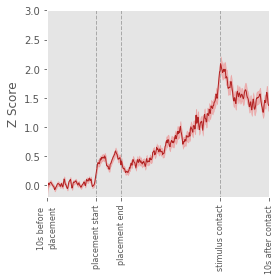

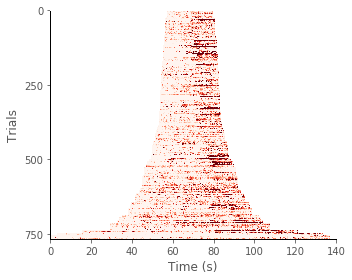

In [5]:
savepath2 = 'F:/Figures_median/F3data/'
func_format.foldercheck(savepath)

fig1 = plot_sorted_timewarp(timewarpresults, 0, 5, 'Reds')
fig1.savefig(savepath+'BLAresponsive_fig1.png', dpi = 300)
#plt.rcParams['svg.fonttype'] = 'none'
#fig1.savefig(savepath+'allneuronstimewarp.svg', format = 'svg', dpi = 300, transparent = True)

[fig2, meantrace, semtrace] = plot_populationtimewarp(timewarpresults)
fig2.savefig(savepath+'BLAresponsive_fig2.png', dpi = 300)

fig, ax = plt.subplots(1, figsize = (5, 4))

[heatmap_masked, sortorder] = order_pad_mask(zscoreresults)
ax.imshow(heatmap_masked, aspect = 'auto', vmin = 0, vmax = 5, cmap = 'Reds')
ax.set_ylim(len(heatmap_masked), 0)
ax.set_facecolor('white')
ax.set_yticks((0, 250, 500, 750))
ax.set_ylabel('Trials')
ax.set_xticks((0,200,400,600,800,1000,1200, 1400))
ax.set_xticklabels((0,20,40,60,80,100,120,140))
ax.set_xlabel('Time (s)')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.grid(False)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(savepath+'BLAresponsive.png', dpi = 300)

np.savetxt(savepath2+'BLAresponsive_text1.csv', np.vstack((meantrace, semtrace)), delimiter = ',', fmt = '%s')
np.savetxt(savepath2+'BLAresponsive_text2.csv', rawvaluesave, delimiter = ',', fmt = '%s')

In [29]:
##### Calculate for panresponsive only

neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

#func_format.foldercheck(savepath)

zscoreresults = []
velocityresults = []
timewarpresults = np.zeros(449)
idinfosave = np.zeros(7)

intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
#neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]

### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response
rawvaluesave = np.zeros(5)
for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    if row[3] != 'multimodal':
        continue
        
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    
    for j, row2 in enumerate(intdetails):
        if np.isin(row2[2], usableint) == True:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            presentationstart = np.float32(sync[np.int(row2[3])])
            contactstart = np.float32(sync[np.int(row2[7])])
            presentationstop = np.float32(sync[np.int(row2[5])])
            
            ### insert behavioral exclusion conditions here (i.e. at least 5s in between presentation and contact)
            if (contactstart - presentationstop) < 1:
                continue
            [zscore_fr, bins, meanbaseline] = calculate_zscore(neuron, presentationstart-10, contactstart+10, 
                                         presentationstart-300, presentationstart, 0.1)
            zscoreresults.append([zscore_fr])
            
            #### timewarps data
            placementstop = np.argmin(np.abs(bins - presentationstop))
            contactbin = np.argmin(np.abs(bins - contactstart))
            beforepresentationfr = zscore_fr[:100]
            placementfr = zscore_fr[100:placementstop]
            beforecontactfr = zscore_fr[placementstop:contactbin]
            aftercontactfr = zscore_fr[contactbin:contactbin+99]
            rawvalues = (meanbaseline, np.mean(beforepresentationfr), np.mean(placementfr), np.mean(beforecontactfr), np.mean(aftercontactfr))
            rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            placementfr = timewarp_interpolate(placementfr, 50)
            beforecontactfr = timewarp_interpolate(beforecontactfr, 200)
            timewarp_fr = np.hstack((beforepresentationfr, placementfr, beforecontactfr, aftercontactfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))
            
            idinfo = np.hstack((row[0], row[1], row[2], row2[2], np.ravel(intcat)[np.ravel(foldername) == row2[2]][0], np.ravel(inttype)[np.ravel(foldername) == row2[2]][0], np.ravel(presentationnumber)[np.ravel(foldername) == row2[2]][0]))
            
            idinfosave = np.vstack((idinfosave, idinfo))
            
timewarpresults = timewarpresults[1:]
idinfosave = idinfosave[1:]
            
            
            
            

In [54]:
allresults = np.hstack((idinfosave, timewarpresults))

In [57]:
sortorder = np.argsort(np.mean(timewarpresults[:, 100:150], axis = 1))

sortedresults = np.take_along_axis(allresults, sortorder.reshape(-1,1), axis = 0)

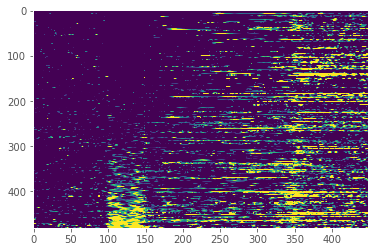

In [65]:
plt.imshow(np.array(sortedresults[:,7:], np.float), aspect = 'auto', vmin = 1, vmax = 3)
plt.grid(False)

In [96]:
np.count_nonzero(neuronprofile[:,3] == 'multimodal')

37

In [137]:
allidinfosave = []
for i, ii in enumerate(idinfosave):
    allidinfo = ii[0]+ii[1]+ii[2]
    allidinfosave = np.append(allidinfosave, allidinfo)

In [126]:
preparatoryresponse = idinfosave[np.mean(timewarpresults[:,100:150], axis = 1) > 1]

In [145]:
combinedidsave = []

for i, ii in enumerate(preparatoryresponse):
    combinedid = ii[0]+ii[1]+ii[2]

    combinedidsave = np.append(combinedidsave, combinedid)

In [146]:
unique = np.unique(combinedidsave)

In [151]:
prepneurons = []

for i, ii in enumerate(unique):
    
    if np.count_nonzero(combinedidsave == ii) > 2:
        
        prepneurons = np.append(prepneurons, ii)

In [152]:
timewarp_prepneurons = np.zeros(449)
timewarp_nonprepneurons = np.zeros(449)

for i, ii in enumerate(allidinfosave):
    
    if np.count_nonzero(prepneurons == ii) > 0:
        timewarp_prepneurons = np.vstack((timewarp_prepneurons, timewarpresults[i]))
    else:
        timewarp_nonprepneurons = np.vstack((timewarp_nonprepneurons, timewarpresults[i]))

In [165]:
for i, ii in enumerate(prepneurons):
    print(ii)

Amygdala102706202042A
Amygdala102706202045A
Amygdala102706202047A
Amygdala102706202048A
Amygdala110607202042A
Amygdala110607202077A
Amygdala61304201958A
Amygdala61304201963A
Amygdala61304201966A
Amygdala80110201926A
Amygdala80110201963B
Amygdala80110201983A
Amygdala80110201995A


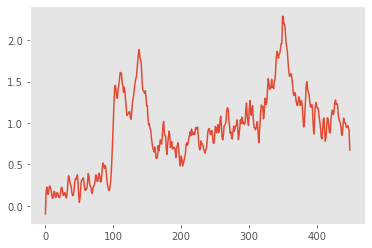

In [159]:
plt.plot(np.mean(timewarp_prepneurons, axis = 0))
plt.grid(False)

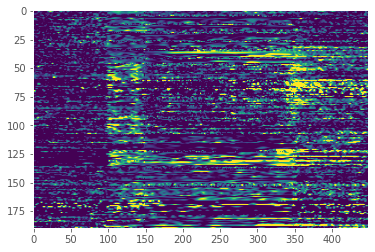

In [162]:
plt.imshow(timewarp_prepneurons, aspect = 'auto', vmin = 0, vmax = 5)
plt.grid(False)

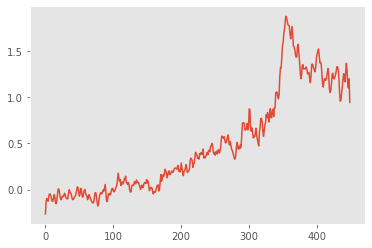

In [161]:
plt.plot(np.mean(timewarp_nonprepneurons, axis = 0))
plt.grid(False)

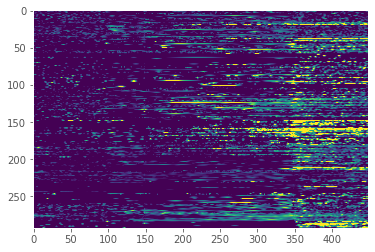

In [163]:
plt.imshow(timewarp_nonprepneurons, aspect = 'auto', vmin = 0, vmax = 5)
plt.grid(False)

In [64]:
np.savetxt('F:/sortedresults_panplacementactivity.csv', sortedresults, delimiter = ',', fmt = '%s')

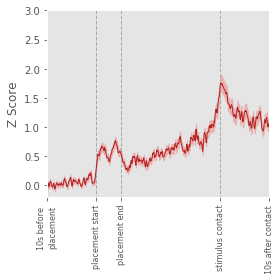

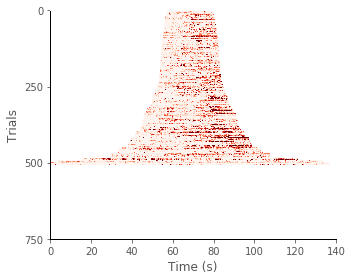

In [7]:


fig1 = plot_sorted_timewarp(timewarpresults, 0, 5, 'Reds')
fig1.savefig(savepath+'panresponsive_fig1.png', dpi = 300)
#plt.rcParams['svg.fonttype'] = 'none'
#fig1.savefig(savepath+'allneuronstimewarp.svg', format = 'svg', dpi = 300, transparent = True)

[fig2, meantrace, semtrace] = plot_populationtimewarp(timewarpresults)
fig2.savefig(savepath+'panresponsive_fig2.png', dpi = 300)

fig, ax = plt.subplots(1, figsize = (5, 4))

[heatmap_masked, sortorder] = order_pad_mask(zscoreresults)
ax.imshow(heatmap_masked, aspect = 'auto', vmin = 0, vmax = 5, cmap = 'Reds')
ax.set_ylim(len(heatmap_masked), 0)
ax.set_facecolor('white')
ax.set_yticks((0, 250, 500, 750))
ax.set_ylabel('Trials')
ax.set_xticks((0,200,400,600,800,1000,1200, 1400))
ax.set_xticklabels((0,20,40,60,80,100,120,140))
ax.set_xlabel('Time (s)')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.grid(False)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(savepath+'panresponsive.png', dpi = 300)

np.savetxt(savepath2+'panresponsive_text1.csv', np.vstack((meantrace, semtrace)), delimiter = ',', fmt = '%s')
np.savetxt(savepath2+'panresponsive_text2.csv', rawvaluesave, delimiter = ',', fmt = '%s')

In [9]:


neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

zscoreresults = []
velocityresults = []
timewarpresults = np.zeros(449)

intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
#neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA_median/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]

### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response
rawvaluesave = np.zeros(5)
for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    if row[3] != 'unimodal':
        continue
        
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    
    for j, row2 in enumerate(intdetails):
        if np.isin(row2[2], usableint) == True:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            presentationstart = np.float32(sync[np.int(row2[3])])
            contactstart = np.float32(sync[np.int(row2[7])])
            presentationstop = np.float32(sync[np.int(row2[5])])
            
            ### insert behavioral exclusion conditions here (i.e. at least 5s in between presentation and contact)
            if (contactstart - presentationstop) < 1:
                continue
            [zscore_fr, bins, meanbaseline] = calculate_zscore(neuron, presentationstart-10, contactstart+10, 
                                         presentationstart-300, presentationstart, 0.1)
            zscoreresults.append([zscore_fr])
            
            #### timewarps data
            placementstop = np.argmin(np.abs(bins - presentationstop))
            contactbin = np.argmin(np.abs(bins - contactstart))
            beforepresentationfr = zscore_fr[:100]
            placementfr = zscore_fr[100:placementstop]
            beforecontactfr = zscore_fr[placementstop:contactbin]
            aftercontactfr = zscore_fr[contactbin:contactbin+99]
            rawvalues = (meanbaseline, np.mean(beforepresentationfr), np.mean(placementfr), np.mean(beforecontactfr), np.mean(aftercontactfr))
            rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            placementfr = timewarp_interpolate(placementfr, 50)
            beforecontactfr = timewarp_interpolate(beforecontactfr, 200)
            timewarp_fr = np.hstack((beforepresentationfr, placementfr, beforecontactfr, aftercontactfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))

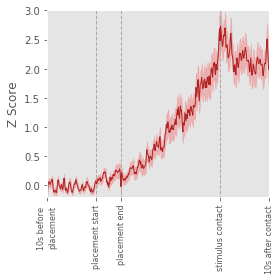

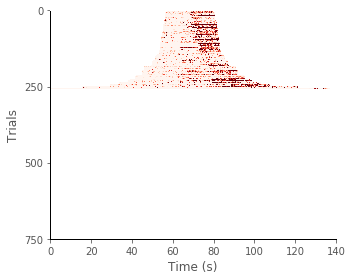

In [10]:


fig1 = plot_sorted_timewarp(timewarpresults, 0, 5, 'Reds')
fig1.savefig(savepath+'unimodal_fig1.png', dpi = 300)
#plt.rcParams['svg.fonttype'] = 'none'
#fig1.savefig(savepath+'allneuronstimewarp.svg', format = 'svg', dpi = 300, transparent = True)

[fig2, meantrace, semtrace] = plot_populationtimewarp(timewarpresults)
fig2.savefig(savepath+'unimodal_fig2.png', dpi = 300)

fig, ax = plt.subplots(1, figsize = (5, 4))

[heatmap_masked, sortorder] = order_pad_mask(zscoreresults)
ax.imshow(heatmap_masked, aspect = 'auto', vmin = 0, vmax = 5, cmap = 'Reds')
ax.set_ylim(len(heatmap_masked), 0)
ax.set_facecolor('white')
ax.set_yticks((0, 250, 500, 750))
ax.set_ylabel('Trials')
ax.set_xticks((0,200,400,600,800,1000,1200, 1400))
ax.set_xticklabels((0,20,40,60,80,100,120,140))
ax.set_xlabel('Time (s)')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.grid(False)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(savepath+'unimodal.png', dpi = 300)

np.savetxt(savepath2+'unimodal_text1.csv', np.vstack((meantrace, semtrace)), delimiter = ',', fmt = '%s')
np.savetxt(savepath2+'unimodal_text2.csv', rawvaluesave, delimiter = ',', fmt = '%s')

In [11]:
##### Calculate for panresponsive only

neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

zscoreresults = []
velocityresults = []
timewarpresults = np.zeros(449)

intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
#neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA_median/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]

### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response
rawvaluesave = np.zeros(5)
for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    if row[3] != 'NoResponses':
        continue
        
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    
    for j, row2 in enumerate(intdetails):
        if np.isin(row2[2], usableint) == True:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            presentationstart = np.float32(sync[np.int(row2[3])])
            contactstart = np.float32(sync[np.int(row2[7])])
            presentationstop = np.float32(sync[np.int(row2[5])])
            
            ### insert behavioral exclusion conditions here (i.e. at least 5s in between presentation and contact)
            if (contactstart - presentationstop) < 1:
                continue
            [zscore_fr, bins, meanbaseline] = calculate_zscore(neuron, presentationstart-10, contactstart+10, 
                                         presentationstart-300, presentationstart, 0.1)
            zscoreresults.append([zscore_fr])
            
            #### timewarps data
            placementstop = np.argmin(np.abs(bins - presentationstop))
            contactbin = np.argmin(np.abs(bins - contactstart))
            beforepresentationfr = zscore_fr[:100]
            placementfr = zscore_fr[100:placementstop]
            beforecontactfr = zscore_fr[placementstop:contactbin]
            aftercontactfr = zscore_fr[contactbin:contactbin+99]
            rawvalues = (meanbaseline, np.mean(beforepresentationfr), np.mean(placementfr), np.mean(beforecontactfr), np.mean(aftercontactfr))
            rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            placementfr = timewarp_interpolate(placementfr, 50)
            beforecontactfr = timewarp_interpolate(beforecontactfr, 200)
            timewarp_fr = np.hstack((beforepresentationfr, placementfr, beforecontactfr, aftercontactfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide


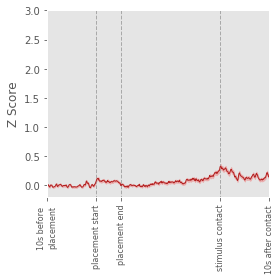

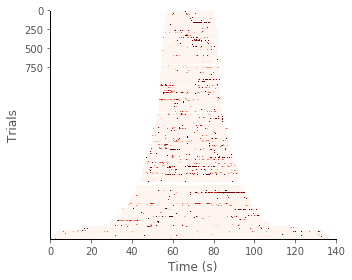

In [12]:


fig1 = plot_sorted_timewarp(timewarpresults, 0, 5, 'Reds')
fig1.savefig(savepath+'noresponses_fig1.png', dpi = 300)
#plt.rcParams['svg.fonttype'] = 'none'
#fig1.savefig(savepath+'allneuronstimewarp.svg', format = 'svg', dpi = 300, transparent = True)

[fig2, meantrace, semtrace] = plot_populationtimewarp(timewarpresults)
fig2.savefig(savepath+'noresponses_fig2.png', dpi = 300)

fig, ax = plt.subplots(1, figsize = (5, 4))

[heatmap_masked, sortorder] = order_pad_mask(zscoreresults)
ax.imshow(heatmap_masked, aspect = 'auto', vmin = 0, vmax = 5, cmap = 'Reds')
ax.set_ylim(len(heatmap_masked), 0)
ax.set_facecolor('white')
ax.set_yticks((0, 250, 500, 750))
ax.set_ylabel('Trials')
ax.set_xticks((0,200,400,600,800,1000,1200, 1400))
ax.set_xticklabels((0,20,40,60,80,100,120,140))
ax.set_xlabel('Time (s)')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.grid(False)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(savepath+'noresponses.png', dpi = 300)

np.savetxt(savepath2+'noresponses_text1.csv', np.vstack((meantrace, semtrace)), delimiter = ',', fmt = '%s')
np.savetxt(savepath2+'noresponses_text2.csv', rawvaluesave, delimiter = ',', fmt = '%s')

In [17]:
panresponsive = np.array(np.loadtxt(savepath2+'/panresponsive_text1.csv', delimiter = ',', dtype = str), np.float)
unimodal = np.array(np.loadtxt(savepath2+'/unimodal_text1.csv', delimiter = ',', dtype = str), np.float)
nonresponsive = np.array(np.loadtxt(savepath2+'/noresponses_text1.csv', delimiter = ',', dtype = str), np.float)



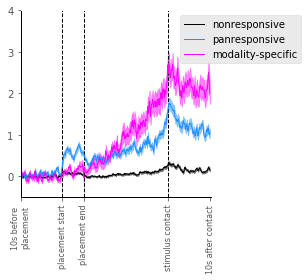

In [18]:
fig, ax = plt.subplots(1, figsize = (5, 4))

ax.plot(nonresponsive[0], color = 'black', lw = 1)
ax.plot(panresponsive[0], color = 'dodgerblue', lw =1)
ax.plot(unimodal[0], color = 'magenta', lw = 1)

ax.fill_between(np.arange(0, len(nonresponsive[0])), nonresponsive[0]-nonresponsive[1], nonresponsive[0]+nonresponsive[1], color = 'black', alpha = 0.5)
ax.fill_between(np.arange(0, len(panresponsive[0])), panresponsive[0]-panresponsive[1], panresponsive[0]+panresponsive[1], color = 'dodgerblue', alpha = 0.5)
ax.fill_between(np.arange(0, len(unimodal[0])), unimodal[0]-unimodal[1], unimodal[0]+unimodal[1], color = 'magenta', alpha = 0.5)

ax.legend(('nonresponsive', 'panresponsive', 'modality-specific'), bbox_to_anchor = (1.5,1))
ax.set_ylim(-.5, 4)
ax.set_xlim(0,450)
ax.set_xticks((0, 99, 149, 349, 448))
ax.set_xticklabels(('10s before \nplacement', 'placement start', 'placement end', 'stimulus contact', '10s after contact'), 
            rotation = 90, fontsize = 8)
ax.set_yticks((0, 1, 2, 3, 4))
ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.vlines(99, ymin = -.5, ymax = 4, lw = 1, linestyle = '--')
ax.vlines(149, ymin = -.5, ymax = 4, lw = 1, linestyle = '--')
ax.vlines(349, ymin = -.5, ymax = 4, lw = 1, linestyle = '--')
plt.grid(False)

plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(savepath+'/F3_neuronalfiringstart.png', dpi = 300)
plt.savefig(savepath+'/F3_neuronalfiringstart.svg', format = 'svg', dpi = 300, transparent = True)
#plt.savefig('F:/Figure3/summaryneuronfiringstart.svg', format = 'svg', dpi = 500, transparent = True)

#plt.savefig('F:/InteractionStart_BLA/summarygraph1.png', dpi = 300)

In [15]:
nonresponsive = np.loadtxt(savepath2+'/noresponses_text2.csv', delimiter = ',', dtype = np.float)[1:]
panresponsive = np.loadtxt(savepath2+'/panresponsive_text2.csv', delimiter = ',', dtype = np.float)[1:]
unimodal = np.loadtxt(savepath2+'/unimodal_text2.csv', delimiter = ',', dtype = np.float)[1:]

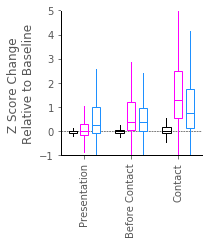

In [16]:
fig, ax = plt.subplots(figsize = (3, 3.5))

ax.plot((-1,20), (0, 0), color = 'black', lw = .5, linestyle = '--')


ax.boxplot((nonresponsive[np.isnan(nonresponsive[:,2]) == False, 2] - nonresponsive[np.isnan(nonresponsive[:,1]) == False, 1], 
           nonresponsive[np.isnan(nonresponsive[:,3]) == False, 3] - nonresponsive[np.isnan(nonresponsive[:,1]) == False, 1],
           nonresponsive[np.isnan(nonresponsive[:,4]) == False, 4] - nonresponsive[np.isnan(nonresponsive[:,1]) == False, 1]),
           positions = (0,4,8), 
           showcaps = False, showfliers = False, patch_artist=True, boxprops=dict(facecolor = 'white', color='black', linewidth=1),
          whiskerprops=dict(color='black', linewidth=1), medianprops=dict(color='black'), widths = 0.7)


ax.boxplot((unimodal[:,2]-unimodal[:,1], 
            unimodal[:,3]-unimodal[:,1], 
            unimodal[:,4]-unimodal[:,1]), 
           positions = (1, 5, 9), showcaps = False, showfliers = False, 
           patch_artist=True, boxprops=dict(facecolor='white', color = 'magenta', linewidth = 1), whiskerprops = dict(color = 'magenta', linewidth=1), medianprops=dict(color = 'magenta'), widths = 0.7)

ax.boxplot((panresponsive[:,2]-panresponsive[:,1],
            panresponsive[:,3]-panresponsive[:,1], 
            panresponsive[:,4]-panresponsive[:,1]), positions= (2, 6, 10), showcaps = False, showfliers = False, patch_artist=True, boxprops = dict(facecolor = 'white', color = 'dodgerblue', linewidth = 1), whiskerprops = dict(color = 'dodgerblue', linewidth = 1), medianprops = dict(color = 'dodgerblue'), widths = 0.7)

ax.set_xticks((1, 5, 9))
ax.set_xticklabels(('Presentation', 'Before Contact', 'Contact'), rotation = 90)
ax.set_xlim(-1, 11)
ax.set_ylabel('Z Score Change \nRelative to Baseline')
ax.set_ylim(-1, 5)

ax.set_facecolor('white')
ax.grid(False)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.set_yticks((-1,0,1,2,3,4,5))

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(savepath+'/F3_quantification.png', dpi = 300)
plt.savefig(savepath+'/F3_quantification.svg', format = 'svg', dpi = 300, transparent = True)
#plt.savefig('F:/Figure3/Quantification.svg', format = 'svg', dpi = 500, transparent = True)
#plt.savefig('F:/FigurePlots/Firingstartquantification.png', dpi = 300)
plt.show()